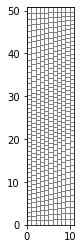

0
---------  --------------
sim_name   disu-d-af-vo-s
crossflow  False
staggered  False
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.21507120840803  18.13696542671794
avg channel  1.20996374980589  16.38420257823995
min channel  0.53418756419740   2.31330437559244
max channel  1.85425510377250  34.85533823158293
1
---------  --------------
sim_name   disu-d-af-vo-x
crossflow  False
staggered  False
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  0.98158495516016  22.81628475873673
avg channel  1.01892200788652  19.87458818052787
min channel  0.39270322475778   2.74734354130716
max channel  1.66406658587636  41.65304066451004
2
---------

In [1]:
scenario = 2 # 0: VO, 1: VO-XT3D, 2: VS, 3: VS-XT3D

%run ./disu_approach_resolution.ipynb
logfunc = lambda e: np.log10(e)

In [2]:
dip = np.arange(0,75,1) # For nice contours use (0,80,1)
log = np.arange(0, 4.2, 0.2) # For nice contours use (0,4,0.2)
Kcontrast = [10**i for i in log]
qmag_results = np.zeros((len(Kcontrast), len(dip)))
qtheta_results = np.zeros((len(Kcontrast), len(dip)))
dip_array = np.zeros((len(Kcontrast), len(dip)))
Kcontrast_array = np.zeros((len(Kcontrast), len(dip)))
Kcontrast

[1.0,
 1.5848931924611136,
 2.51188643150958,
 3.981071705534973,
 6.309573444801933,
 10.0,
 15.848931924611142,
 25.11886431509581,
 39.810717055349734,
 63.09573444801933,
 100.0,
 158.48931924611142,
 251.18864315095823,
 398.1071705534973,
 630.9573444801937,
 1000.0,
 1584.893192461114,
 2511.886431509582,
 3981.0717055349733,
 6309.573444801937,
 10000.0]

In [3]:
for kc in range(len(Kcontrast)):
    for d in range(len(dip)):

        nlay_chan = 5                   # number of layers in channel, and number of columns in model
        Lx = 11.0                       # full horizontal width of model
        theta = dip[d]                  # angle of inclination of channel
        k_dom = 1/Kcontrast[kc]         # domain conductivity
        #theta = math.atan(0.5) * 180. / math.pi
        domain = True                   # option to include "domain" (True) or not (False)

        nrow = 1                        # model is one row deep "into the page"
        delc = 1.                       # model has unit width "into the page"

        # computed grid parameters
        if domain:
            nlay_dom_upper = nlay_chan                      # number of layers in upper domain
        else:
            nlay_dom_upper = 0
        nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
        nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
        delr = float(Lx / ncol)                             # horizontal cell size
        delz_chan = delr                                    # vertical cell size in channel
        zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
        zthick = nlay_chan * delz_chan                      # vertical thickness of channel
        zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel
        zthick_dom_ll = zthick                              # vertical thickness of lower domain at left boundary
        zthick_dom_ur = zthick                              # vertical thickness of upper domain at right boundary

        ncol = int(Lx/delz_chan)

        # set tops, bottoms, and conductivities; midpoints of cell tops/bottoms fall along
        # the "true" top/bottom channel boundaries
        botm = np.empty((nlay, nrow, ncol))
        cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
        top_chan = zthick + 0.5 * zoffset \
            + np.linspace(0., (ncol - 1) * zoffset, ncol)
        top_chan = top_chan.reshape((nrow, ncol))           # top of channel (without domain)
        if domain:
            # upper domain
            Lz = zthick_dom_ll + zspan + zthick_dom_ur      # total height of model
            top_chan += zthick_dom_ll                       # add left-boundary thickness of lower domain to top of channel
            top = np.ones((nrow, ncol)) * Lz                # top of model
            dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
            botm[0] = top - dz                              # bottom of first layer is calculated using top
            cond[0] = k_dom
            for klay in range(1, nlay_dom_upper):
                botm[klay] = botm[klay - 1] - dz
                cond[klay] = k_dom
            # prepare to continue with channel discretization
            klaycontinue = nlay_dom_upper
        else:
            # initialize channel discretization
            Lz = zspan                                     # total height of model
            top = top_chan                                 # top of model is top of channel
            botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
            # prepare to continue channel discretization
            klaycontinue = 1
        # channel
        for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
            botm[klay] = botm[klay - 1] - delz_chan
        if domain:
            # lower domain
            dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
            for klay in range(nlay_dom_upper + nlay_chan, nlay):
                botm[klay] = botm[klay - 1] - dz
                cond[klay] = k_dom

        # plot dis grid
        delr = delr * np.ones(ncol, dtype=float)
        delc = delc * np.ones(nrow, dtype=float)
        mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                                  top=top, botm=botm)

        # run scenarios
        for s in range(scenario,scenario + 1): 
            print('\nk_contrast = %i, dip = %i, scenario = %i' %(Kcontrast[kc], dip[d], s))
            qmagmid, qangmid = simulation(s)
            qmag_results[kc][d] = abs(qmagmid - 1) # error
            qtheta_results[kc][d] = abs((qangmid - theta)/theta) # error
            
            Kcontrast_array[kc][d] = Kcontrast[kc]
            dip_array[kc][d] = dip[d]


k_contrast = 1, dip = 0, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000   0.00000000000000
mid-channel  1.00000018135613  -0.00003432927279
avg channel  0.99999998663607  -0.00001626623315
min channel  0.99999808167984  -0.00004787575112
max channel  1.00000168263836   0.00000745835725

k_contrast = 1, dip = 1, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  0.99160598084433  1.00508018546107
avg channel  0.99158478486007  1.00619176374202
min channel  0.99147189387490  1.00455238


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  13.00000000000000
mid-channel  0.93990630774048  13.66133545884911
avg channel  0.93960445562244  13.69023711637919
min channel  0.92854096449106  13.50853214597818
max channel  0.94771828578139  13.88193886499753

k_contrast = 1, dip = 14, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  0.93956252701658  14.74238919001229
avg channel  0.93940375951130  14.75797139153459
min channel  0.92686209076438  14.55222066642290
max channel  0.94857608690228  14.98123103089777

k_contrast = 1, dip = 15, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  0.98424808814122  27.39899018706898
avg channel  0.98722731452942  26.71427505697099
min channel  0.94894951756415  25.07382974020177
max channel  1.03441690220043  27.57557195953253

k_contrast = 1, dip = 27, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  0.99225712513189  28.39609935313309
avg channel  0.99543072242186  27.59767091637941
min channel  0.95406843350900  25.67388174304644
max channel  1.04787605025076  28.56824944664502

k_contrast = 1, dip = 28, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.14938687668535  39.10628324464166
avg channel  1.14780767321572  36.25621582352478
min channel  1.06219938025039  29.25472860902736
max channel  1.28776158296623  39.27741379514589

k_contrast = 1, dip = 40, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.16837522975051  39.87596785678688
avg channel  1.16542334284618  36.80424530889886
min channel  1.07557324143604  29.26423079052570
max channel  1.3149298941

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  52.00000000000000
mid-channel  0.93337463267484  82.84150778799126
avg channel  0.91704015308772  72.49363063549879
min channel  0.80333948896626  48.35177036417225
max channel  1.05456326145023  88.62392345706323

k_contrast = 1, dip = 53, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  53.00000000000000
mid-channel  0.94401176293190  82.10372288070326
avg channel  0.93276963290852  71.54282954013028
min channel  0.80662098178999  47.55358691357996
max channel  1.0822955821

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   65.00000000000000
mid-channel  1.35443319065117  127.95401075457087
avg channel  1.05191832167843   99.74410770326517
min channel  0.78188428673098   44.52432600081593
max channel  1.35835887416377  127.95401075457087

k_contrast = 1, dip = 66, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   66.00000000000000
mid-channel  1.30236914466207  126.41728513238483
avg channel  1.03276787290187   96.61095197101166
min channel  0.75752672626911   54.90397928115267
max channel 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  0.97699985741176  3.01539845975842
avg channel  0.95519362711797  2.96107797501133
min channel  0.86982634541258  2.71284996587684
max channel  0.97726736694222  3.07245679640184

k_contrast = 1, dip = 4, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  4.00000000000000
mid-channel  0.97069412295651  4.02625049236982
avg channel  0.94904123765037  3.96023141004431
min channel  0.86555083337646  3.63806053750169
max channel  0.97122717026308  4.124701

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  16.00000000000000
mid-channel  0.94292165684465  16.17096313820512
avg channel  0.92252882432255  15.98454129485975
min channel  0.86342921514460  14.87330506741336
max channel  0.95753972240699  16.95478995042453

k_contrast = 1, dip = 17, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  17.00000000000000
mid-channel  0.94441074291958  17.16677316347206
avg channel  0.92421596460452  16.95294948191356
min channel  0.86686015243746  15.75054581939134
max channel  0.9610205378

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.00904240893423  28.52643607784533
avg channel  0.99121892891893  27.42638631124504
min channel  0.91070295380799  23.92691213487216
max channel  1.04744850576707  28.75859330891083

k_contrast = 1, dip = 30, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.01862564594121  29.40691717699039
avg channel  1.00079247026008  28.17757335779884
min channel  0.91693697375488  24.35469141051220
max channel  1.0595169374


k_contrast = 1, dip = 42, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  42.00000000000000
mid-channel  1.19810142908221  38.89751378794579
avg channel  1.17060394553777  35.45708114195714
min channel  1.03263465345207  26.05726549585284
max channel  1.31704281889168  39.06357364269268

k_contrast = 1, dip = 43, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  43.00000000000000
mid-channel  1.21961175839076  39.59061049895488
avg channel  1.19005408947281  35.91956150106904
min channel  1.04684439226660  25.

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  0.92118941109946  72.69732207665456
avg channel  0.90697291769187  64.56553257666857
min channel  0.69572780796553  41.10983099232028
max channel  1.14033985172171  78.25013222396656

k_contrast = 1, dip = 56, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  56.00000000000000
mid-channel  0.93615716959504  71.75119676431748
avg channel  0.91949171678499  64.08765052324266
min channel  0.69939421958781  39.30253427962496
max channel  1.1893591957


SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   68.00000000000000
mid-channel  0.98657604397245  109.25742570259457
avg channel  0.92519138192693   80.84979989203090
min channel  0.56453998617283   37.64013051963513
max channel  1.40935273878176  109.25742570259457

k_contrast = 1, dip = 69, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   69.00000000000000
mid-channel  0.95737901438403  106.23667346915026
avg channel  0.94556899751380   76.16121370739977
min channel  0.56232292788995   32.44831751956042
max channel  1.55598929253521  106.23667346915026

k_contrast = 1, dip = 70, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  0.96061082407106  5.96169746908272
avg channel  0.92025882255631  5.76219117988764
min channel  0.76733597459361  4.86210211704420
max channel  0.96258369487688  6.26263523578005

k_contrast = 2, dip = 7, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  7.00000000000000
mid-channel  0.95638117093638  6.94519395987415
avg channel  0.91625631347031  6.72481050614559
min channel  0.76671589020722  5.69694529437830
max channel  0.95921884602310  7.343110

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  0.95107575194864  18.35624982157657
avg channel  0.91307594795891  17.85657058410296
min channel  0.80104157881957  15.52948124348048
max channel  0.97811340781138  19.95423294585388

k_contrast = 2, dip = 20, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  0.95426541243944  19.26468081356640
avg channel  0.91647560126086  18.71985422690694
min channel  0.80676582265200  16.26788771160262
max channel  0.9841108613


k_contrast = 2, dip = 33, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.05037576382893  30.26118853337333
avg channel  1.01306297925517  28.45518615586970
min channel  0.89205359228586  22.96606495421199
max channel  1.10616981857220  30.55060921173208

k_contrast = 2, dip = 34, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.06253625541484  31.03736319170867
avg channel  1.02478755909445  29.07608569565789
min channel  0.89995318398824  23.

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  46.00000000000000
mid-channel  0.81563264820201  75.57105085709246
avg channel  0.74202854949976  69.57995893769190
min channel  0.58617099403715  51.48045680272637
max channel  0.86708983696383  78.31510254070420

k_contrast = 2, dip = 47, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  0.82062905488903  74.48615767181374
avg channel  0.75233549780305  68.68407931911742
min channel  0.58890330896095  50.34236837122011
max channel  0.8804661804

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  59.00000000000000
mid-channel  0.97901870736878  62.16775751627777
avg channel  0.94899695543088  55.56878508535565
min channel  0.64737178910878  30.76206310361908
max channel  1.35002628254850  75.57560395460654

k_contrast = 2, dip = 60, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.00306206409037  61.26442268703962
avg channel  0.97654237788495  54.11852663908456
min channel  0.65618110405740  28.99931403961004
max channel  1.4225588730

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   72.00000000000000
mid-channel  1.09503421209288  130.89304544670486
avg channel  0.85703702652059   95.51531420186022
min channel  0.41501325761995   53.44395175331030
max channel  1.47174951243968  130.89304544670486

k_contrast = 2, dip = 73, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   73.00000000000000
mid-channel  1.01998045842418  131.74402930484612
avg channel  0.87160007415569   87.49771719851130
min channel  0.44099131195741   39.26850408446406
max channel 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  10.00000000000000
mid-channel  0.94826071820888   9.68799634518565
avg channel  0.89367763119566   9.25067810339004
min channel  0.69757471146157   7.35961630505117
max channel  0.95619057952913  10.61029795736110

k_contrast = 3, dip = 11, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  0.94654635929638  10.61820173409327
avg channel  0.89220497756729  10.15296072665303
min channel  0.70037200966670   8.12032471940140
max channel  0.9564027140

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  23.00000000000000
mid-channel  0.96876712116838  21.14312700977919
avg channel  0.91685404950455  20.18432092217230
min channel  0.76567582924443  16.66547359565492
max channel  1.01379871646536  23.59118600705604

k_contrast = 3, dip = 24, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  0.97417732762401  21.96454263305006
avg channel  0.92240579817490  20.93398713658121
min channel  0.77311171185613  17.26246886392777
max channel  1.0224337922


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  36.00000000000000
mid-channel  1.08896108167881  31.14245664784201
avg channel  1.03412946504823  28.66549146677007
min channel  0.87221779118805  21.74137844137140
max channel  1.15428653264226  31.44351505491507

k_contrast = 3, dip = 37, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  37.00000000000000
mid-channel  1.10343681754056  31.85172862814852
avg channel  1.04760746046366  29.20442651670568
min channel  0.88059847832675  21.85717882391654
max channel  1.16664220885769  32.10025556652504

k_contrast = 3, dip = 38, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  49.00000000000000
mid-channel  0.82334777646488  67.67854503383781
avg channel  0.74337279900046  63.98184078014445
min channel  0.54084109891905  45.24039576430810
max channel  0.90492893575406  75.71519637979092

k_contrast = 3, dip = 50, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  50.00000000000000
mid-channel  0.83308806940124  66.49447669974015
avg channel  0.75616304644043  62.86619479754008
min channel  0.54572867255188  43.84854681776725
max channel  0.93112100143377  75.13692197184540

k_contrast = 3, dip = 51, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  62.00000000000000
mid-channel  1.07024871409754  54.75200058968515
avg channel  1.01881841226993  47.64379365280900
min channel  0.62783521343828  23.85456553772902
max channel  1.56641307047864  76.33440944684402

k_contrast = 3, dip = 63, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  63.00000000000000
mid-channel  1.10215912861758  54.05841881586365
avg channel  1.05608950611809  46.11621430860086
min channel  0.63527085009536  22.21267271624616
max channel  1.66984925937496  75.59569988675267

k_contrast = 3, dip = 64, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  0.99168194496859  0.99588322119294
avg channel  0.92022246246030  0.91355486589121
min channel  0.63475142212688  0.64058081264590
max channel  0.99173830316585  1.00854221603202

k_contrast = 6, dip = 2, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  2.00000000000000
mid-channel  0.98415785914597  1.98327587783323
avg channel  0.91371434550865  1.82541747537520
min channel  0.63334952860749  1.28881650168154
max channel  0.98440387638312  2.033367


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  0.94572439755171  13.11954120140305
avg channel  0.88098702537745  12.39047347469718
min channel  0.66021614030564   9.53312339588728
max channel  0.96459884589548  14.92618617711892

k_contrast = 6, dip = 15, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  0.94629852733034  13.98578573857391
avg channel  0.88181441976485  13.21815660734851
min channel  0.66546582873501  10.23094520139768
max channel  0.96816236970513  15.97812923670334

k_contrast = 6, dip = 16, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  0.99515540074678  23.65716871920882
avg channel  0.93245733260116  22.14133251573839
min channel  0.75077122220614  17.59336219249471
max channel  1.05829620590194  26.71424354295148

k_contrast = 6, dip = 28, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  28.00000000000000
mid-channel  1.00291822576172  24.40629880983489
avg channel  0.94013376478373  22.79086539348783
min channel  0.75909906156953  18.05644379823586
max channel  1.0688930714

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.15353060209188  32.81961525322739
avg channel  1.08037267063216  29.45921322726718
min channel  0.85903508621106  20.73731098291831
max channel  1.21156729513766  33.02074094716869

k_contrast = 6, dip = 41, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.17204503539696  33.47788126937679
avg channel  1.09674298595647  29.93193874193053
min channel  0.86653554490391  20.70613252320033
max channel  1.2244487067


k_contrast = 6, dip = 54, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  0.89360088903108  58.46179648678225
avg channel  0.80087150800732  55.53248558782897
min channel  0.53583536513410  36.41585323469346
max channel  1.04399270698278  76.70123998985905

k_contrast = 6, dip = 55, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  0.91255185898764  57.42007756444313
avg channel  0.82020462621540  54.25917115423516
min channel  0.54406224391738  34.


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  0.86737022392152  78.83477362570272
avg channel  0.76398321437105  71.19459877607770
min channel  0.38996282423937  39.67992667090412
max channel  1.33836401822530  88.05300387549946

k_contrast = 6, dip = 68, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  0.86973349618147  75.80876419031526
avg channel  0.79170205852960  66.08896556615429
min channel  0.41241713338317  33.66891837434151
max channel  1.38963087981522  85.25082162010222

k_contrast = 6, dip = 69, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  F

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  5.00000000000000
mid-channel  0.96614506695713  4.86996514665579
avg channel  0.88947382771935  4.46099076597396
min channel  0.59067281818163  3.05181253815242
max channel  0.96820435569541  5.19129332951802

k_contrast = 10, dip = 6, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  0.96152008395988  5.81192619173099
avg channel  0.88552287986188  5.33894963420902
min channel  0.59235362685786  3.68504158214469
max channel  0.96462120464095  6.26590


k_contrast = 10, dip = 19, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  0.95478085512931  17.07312149268646
avg channel  0.88350133845557  15.95782640869879
min channel  0.65464782313421  12.19210458915306
max channel  0.99253396162225  20.01614791604567

k_contrast = 10, dip = 20, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  0.95804438915525  17.86662921704934
avg channel  0.88697100707535  16.69434241850665
min channel  0.66181248036784  1


k_contrast = 10, dip = 33, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.05287601726357  27.39629478945918
avg channel  0.97990446805376  24.99344128347783
min channel  0.76871818476679  18.97168505765304
max channel  1.13193272200866  30.27335069137929

k_contrast = 10, dip = 34, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.06484468695816  28.07808246179625
avg channel  0.99103254961880  25.53554295097350
min channel  0.77723985528219  1

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  46.00000000000000
mid-channel  0.79481565816478  66.04883477534504
avg channel  0.67734158323108  63.20720608866835
min channel  0.43652572909137  45.86163514115127
max channel  0.82642597545063  75.45349258749263

k_contrast = 10, dip = 47, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  0.80335625311466  64.63401032387155
avg channel  0.68797334414913  62.04376159197883
min channel  0.44423585250610  44.98313244894108
max channel  0.842218398


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  59.00000000000000
mid-channel  1.02833532201711  51.43063373336232
avg channel  0.90322637546468  47.69223115474440
min channel  0.50487296495394  27.91388322654063
max channel  1.26048283423682  83.77881777649220

k_contrast = 10, dip = 60, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.05868434150196  50.66314611675402
avg channel  0.93245428440348  46.35285155457865
min channel  0.51028677752956  26.24686073103657
max channel  1.32599729137828  83.41728948629034

k_contrast = 10, dip = 61, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   72.00000000000000
mid-channel  0.84601585048068  103.99568479090401
avg channel  0.71672737825612   79.90635171377956
min channel  0.29126150858966   53.45060921479206
max channel  1.40765867548323  103.99568479090401

k_contrast = 10, dip = 73, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000   73.00000000000000
mid-channel  0.81808651979888  103.72717841837893
avg channel  0.75118363899513   73.74254776698440
min channel  0.33985588055960   38.80161985029130
max channel

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  10.00000000000000
mid-channel  0.94958828400954   9.41238523180094
avg channel  0.87009159284566   8.64304573389484
min channel  0.57717375688287   5.97994027622588
max channel  0.95987376450540  10.61892367090758

k_contrast = 15, dip = 11, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  0.94805694181390  10.28818801056395
avg channel  0.86900051927904   9.46532922933256
min channel  0.58164370798104   6.61296814831874
max channel  0.960736420

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  23.00000000000000
mid-channel  0.97175156692497  19.93355630733782
avg channel  0.89588966610662  18.42665642106095
min channel  0.66094857095033  13.93282629215638
max channel  1.02701738745887  23.65509660766995

k_contrast = 15, dip = 24, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  0.97720895577001  20.67227059978517
avg channel  0.90141139949775  19.08800763992264
min channel  0.66907423484366  14.44380567677563
max channel  1.036328924


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  36.00000000000000
mid-channel  1.09256334556025  28.95574115494275
avg channel  1.01025348857472  25.98264709448136
min channel  0.77121110269894  19.06390753783058
max channel  1.17222568768275  31.55803666182393

k_contrast = 15, dip = 37, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  37.00000000000000
mid-channel  1.10720487103090  29.60785487914922
avg channel  1.02330073975508  26.47955807081208
min channel  0.77938727029558  19.21307057386387
max channel  1.18437812740481  31.90401881557320

k_contrast = 15, dip = 38, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  50.00000000000000
mid-channel  0.84304470784051  59.10839517447533
avg channel  0.71758913479618  57.43846666917752
min channel  0.43330100048103  41.38567764002303
max channel  0.90715543128079  84.32421153769776

k_contrast = 15, dip = 51, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  0.85885771167686  57.87890193998663
avg channel  0.73230744040544  56.22002064850317
min channel  0.43987628822854  40.16532909121528
max channel  0.933485535

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  63.00000000000000
mid-channel  1.19348242629341  47.39063998250223
avg channel  1.03303059374139  41.19878307201036
min channel  0.49665276163470  21.50923240123150
max channel  1.53756189339491  84.69410182544648

k_contrast = 15, dip = 64, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  64.00000000000000
mid-channel  0.90769811904476  77.17342041165226
avg channel  0.69152048936735  81.32152885222779
min channel  0.33798749981297  68.65729471558997
max channel  1.177001682


k_contrast = 25, dip = 1, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  1.00000000000000
mid-channel  0.99169692618361  0.99390648833699
avg channel  0.90086457856343  0.88283400198975
min channel  0.53792314196960  0.54237005634777
max channel  0.99176871859528  1.00854858983972

k_contrast = 25, dip = 2, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  2.00000000000000
mid-channel  0.98421324760458  1.97546847520289
avg channel  0.89470522618724  1.76099165696646
min channel  0.53815745382506  1.0930099592983


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  14.00000000000000
mid-channel  0.94707346852503  12.77474214778026
avg channel  0.86559649095710  11.72631478434016
min channel  0.58021541965396   8.26053025544214
max channel  0.96906512307998  14.93972962827043

k_contrast = 25, dip = 15, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  0.94775847176518  13.59497731575523
avg channel  0.86663034333264  12.49242613381512
min channel  0.58636551660046   8.88379655140075
max channel  0.97314587384677  15.99433188024539

k_contrast = 25, dip = 16, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  0.99761197809185  22.62370816908603
avg channel  0.91809315088683  20.67348005918798
min channel  0.67863813297670  15.34990689471142
max channel  1.06901407837012  26.77523026230780

k_contrast = 25, dip = 28, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  28.00000000000000
mid-channel  1.00545395479866  23.31828866168360
avg channel  0.92569432140117  21.26782521403101
min channel  0.68725675689524  15.81829400572752
max channel  1.07994511051492  27.46189199264462

k_contrast = 25, dip = 29, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.15874233826070  31.20264537106534
avg channel  1.06339641929966  27.49452999138215
min channel  0.78728321260184  19.11461909682442
max channel  1.22211263409264  32.76876722900893

k_contrast = 25, dip = 41, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.17781864237080  31.83291100841107
avg channel  1.07942700990882  27.95509051930983
min channel  0.79446233320001  19.12340182228666
max channel  1.233369621

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  53.00000000000000
mid-channel  0.90364627815167  54.57484832932319
avg channel  0.76124106403036  52.96046227309125
min channel  0.43218069992306  37.62088815625851
max channel  0.98818814903143  85.69124238451371

k_contrast = 25, dip = 54, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  0.92592522351047  53.51544853721814
avg channel  0.77986723039922  51.73318135894512
min channel  0.43789321270903  36.23257737551513
max channel  1.017448353


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  66.00000000000000
mid-channel  0.95194546198181  69.98634676793696
avg channel  0.71284750123805  70.47294258630647
min channel  0.36936710831061  52.83352686946764
max channel  1.20853181605315  89.62625590276845

k_contrast = 25, dip = 67, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  0.96602978099430  67.53054862591370
avg channel  0.73686341973836  65.70415026441806
min channel  0.39847995356083  44.85762225239984
max channel  1.24923361762107  89.21540624420443

k_contrast = 25, dip = 68, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 


k_contrast = 39, dip = 5, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  5.00000000000000
mid-channel  0.96633098285000  4.83866121458811
avg channel  0.87736316029112  4.33514309913572
min channel  0.52955414731477  2.72807428029294
max channel  0.96866973731835  5.19169897300371

k_contrast = 39, dip = 6, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  0.96177308675678  5.76714627170823
avg channel  0.87364005916625  5.18247377451717
min channel  0.53217051415737  3.2986417742879

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  18.00000000000000
mid-channel  0.95321608904275  15.91599154039478
avg channel  0.87072414845143  14.58696140333716
min channel  0.59576431511969  10.52872932284099
max channel  0.99045303116746  19.05772807846609

k_contrast = 39, dip = 19, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  0.95601963930877  16.68477486683296
avg channel  0.87378172323037  15.29385262163228
min channel  0.60312688209397  11.12850794086009
max channel  0.997278211

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  31.00000000000000
mid-channel  1.03342026299694  25.19380861834841
avg channel  0.94981463040691  22.73774375715958
min channel  0.70321906594039  16.76043377126184
max channel  1.11593788055618  29.30539191482564

k_contrast = 39, dip = 32, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  32.00000000000000
mid-channel  1.04401210596586  25.85525816540196
avg channel  0.95962569598640  23.27526574294124
min channel  0.71191020546393  17.20040791186835
max channel  1.127827664

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  1.24498447026997  33.47794079969611
avg channel  1.13042006524845  29.03118998714488
min channel  0.80346950420455  18.77713609916521
max channel  1.26515421671164  33.55176971589439

k_contrast = 39, dip = 45, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79230468792196  63.97191246322245
avg channel  0.66561623053363  61.71225817317746
min channel  0.37124235040998  27.15646682143953
max channel  0.999799284


k_contrast = 39, dip = 57, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  57.00000000000000
mid-channel  1.01596553011404  50.07083554998241
avg channel  0.84099531829621  47.77463035679813
min channel  0.43876090228707  32.13200995956592
max channel  1.10852540408149  88.34263320842284

k_contrast = 39, dip = 58, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  58.00000000000000
mid-channel  1.04836507296865  49.24802308419555
avg channel  0.86619564900495  46.53973236683878
min channel  0.44364468619406  3


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  70.00000000000000
mid-channel  1.06885443452347  58.66667618988356
avg channel  0.85308889371776  51.98329280292548
min channel  0.49229212938307  28.36224192274174
max channel  1.38686114885636  89.37840435943478

k_contrast = 39, dip = 71, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  71.00000000000000
mid-channel  1.09642683928397  56.09875170934733
avg channel  0.91197254750798  48.14193558744279
min channel  0.49343530815041  23.74517071962245
max channel  1.47937765040134  90.09973072777139

k_contrast = 39, dip = 72, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 


SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  8.00000000000000
mid-channel  0.95465127362728  7.57460449886843
avg channel  0.86634869888590  6.82235735574038
min channel  0.53100100201451  4.39530259718306
max channel  0.96139979055119  8.43764835581518

k_contrast = 63, dip = 9, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  9.00000000000000
mid-channel  0.95200230185106  8.46122693852586
avg channel  0.86432148369869  7.63954056698347
min channel  0.53512684772577  4.97976566434410
max channel  0.96075880641749  9.52902300033110

k_contrast = 63, dip = 10, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggere


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  21.00000000000000
mid-channel  0.96339555981279  18.13142794033509
avg channel  0.88011677776769  16.56643648581978
min channel  0.61165795121198  11.92367789881326
max channel  1.01339499686675  21.91511459838597

k_contrast = 63, dip = 22, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  22.00000000000000
mid-channel  0.96780405526711  18.86486689365923
avg channel  0.88466735637240  17.22758160089380
min channel  0.61967934039149  12.40141112475694
max channel  1.02194369506365  22.81059947614832

k_contrast = 63, dip = 23, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.06795678675368  27.04304006574191
avg channel  0.97975229137817  24.15289842780038
min channel  0.72261900513511  17.77159944256137
max channel  1.15296281804555  30.80398143184902

k_contrast = 63, dip = 35, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  35.00000000000000
mid-channel  1.08099059380617  27.68564249374056
avg channel  0.99137499056266  24.65486554377551
min channel  0.73108046164204  18.13332830358900
max channel  1.165085057

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  0.81016770130232  61.08752360154117
avg channel  0.66942000839661  59.41394572026149
min channel  0.37705921602799  44.01628876361232
max channel  0.83457756834673  87.02505505050080

k_contrast = 63, dip = 48, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  0.82312041956891  59.67027853440692
avg channel  0.68145728536639  58.17661393083124
min channel  0.38313858869184  43.26553352456127
max channel  0.857728004

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.13335435074223  47.42750698621364
avg channel  0.92196628456093  43.74929255602363
min channel  0.44566473714527  27.87079777001758
max channel  1.21907232416093  88.73226674117316

k_contrast = 63, dip = 61, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  61.00000000000000
mid-channel  1.17602554292137  46.79308093075623
avg channel  0.95413321610315  42.49440994142744
min channel  0.45006548853495  26.29156412283536
max channel  1.277908947

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  73.00000000000000
mid-channel  0.93937610261916  92.06928867914652
avg channel  0.72820766718690  69.08318648569372
min channel  0.35890652691304  44.35771227581127
max channel  1.25414361701065  92.07271048423293

k_contrast = 63, dip = 74, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  74.00000000000000
mid-channel  0.91021291965727  92.00720547073628
avg channel  0.77308689245289  64.86893736824250
min channel  0.43293376174818  35.46423195675873
max channel  1.252166608


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  0.94851849151684  10.18319869889326
avg channel  0.86094048857753   9.21507312467396
min channel  0.53978778533551   6.10883016033434
max channel  0.96222487362273  11.71139804333680

k_contrast = 100, dip = 12, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  12.00000000000000
mid-channel  0.94760893881181  11.02860326056465
avg channel  0.86051562737651   9.99824667376394
min channel  0.54517285153239   6.70461074705602
max channel  0.96414278835099  12.79689960306781

k_contrast = 100, dip = 13, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflo

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  0.97841005441694  20.25651655687958
avg channel  0.89446875318863  18.43376544172736
min channel  0.63187891005315  13.19511211938892
max channel  1.04102798195575  24.50904669375533

k_contrast = 100, dip = 25, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  25.00000000000000
mid-channel  0.98449735524373  20.95953006833534
avg channel  0.90051992315562  19.05120197054394
min channel  0.64034713607131  13.65107748431327
max channel  1.05098004


k_contrast = 100, dip = 38, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  38.00000000000000
mid-channel  1.12612431916039  29.50588418304363
avg channel  1.02938447032242  25.99558465377392
min channel  0.75135208727143  18.55491734042958
max channel  1.20166876442276  32.28251849484717

k_contrast = 100, dip = 39, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.14313543205652  30.13282124352312
avg channel  1.04375411367946  26.46357145646794
min channel  0.75906329709500 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  0.87446661258246  55.53997268579445
avg channel  0.72250599127690  54.31630382542637
min channel  0.39610496424655  40.46869995527720
max channel  0.93175687385723  88.91318093900507

k_contrast = 100, dip = 52, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  52.00000000000000
mid-channel  0.89486589572813  54.37623143791562
avg channel  0.73879669481303  53.10129168226406
min channel  0.40163820990157  39.34724850992227
max channel  0.95820712


k_contrast = 100, dip = 65, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  0.99977659778645  69.32340693535049
avg channel  0.68810477941424  73.53966871532838
min channel  0.35707620901967  59.54975955156065
max channel  1.10183643566631  89.64600900809869

k_contrast = 100, dip = 66, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  66.00000000000000
mid-channel  1.01947986564313  67.10524071272950
avg channel  0.70682925652335  68.89028233560089
min channel  0.37950645722599 


SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  0.97754231424112  2.93926903079826
avg channel  0.88310022075591  2.59915440293961
min channel  0.50853338902628  1.55802785264567
max channel  0.97833110282069  3.07330102021243

k_contrast = 158, dip = 4, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  4.00000000000000
mid-channel  0.97160317964301  3.89172889915064
avg channel  0.87827518037985  3.45291461796965
min channel  0.51038764851350  2.09485016751647
max channel  0.97308130474203  4.12666144041092

k_contrast = 158, dip = 5, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
stagger

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  16.00000000000000
mid-channel  0.94945313752413  14.26953311143111
avg channel  0.86336048678701  12.98505561194078
min channel  0.56715793029130   9.06051936049286
max channel  0.97971329908622  17.03901124055461

k_contrast = 158, dip = 17, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  17.00000000000000
mid-channel  0.95122976695965  15.05173713852434
avg channel  0.86546474468318  13.70612017497793
min channel  0.57415032517361   9.65867764086227
max channel  0.98535708


k_contrast = 158, dip = 29, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.01500320917539  23.65364624479639
avg channel  0.92937482221410  21.33263177875372
min channel  0.67232214685227  15.32240608920717
max channel  1.09472718948829  28.13557007051040

k_contrast = 158, dip = 30, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.02422255251519  24.31780447993745
avg channel  0.93804328263559  21.88467508086364
min channel  0.68108613883136 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  43.00000000000000
mid-channel  1.22414848526113  32.56049415513764
avg channel  1.10869410317730  28.21309957229215
min channel  0.78402442385983  18.65783081669289
max channel  1.25658766090197  33.40254933240511

k_contrast = 158, dip = 44, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  1.24794599869916  33.17743714852438
avg channel  1.12729832423138  28.66237679464041
min channel  0.78989801701212  18.58755654062053
max channel  1.26597619

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  56.00000000000000
mid-channel  1.00063055232043  50.16872212957993
avg channel  0.81515450961579  48.30960219168437
min channel  0.41939605593166  34.30362825211610
max channel  1.07305231093377  89.58830856724558

k_contrast = 158, dip = 57, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  57.00000000000000
mid-channel  1.03279179071197  49.30555944474723
avg channel  0.83859349147525  47.10303016400181
min channel  0.42425933799511  32.88632297418002
max channel  1.10431269


k_contrast = 158, dip = 69, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  69.00000000000000
mid-channel  1.12015085895456  59.75954235539197
avg channel  0.80238523283190  55.50204180104344
min channel  0.46758860603733  32.65071784928577
max channel  1.21624150377046  90.00527886429653

k_contrast = 158, dip = 70, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  70.00000000000000
mid-channel  1.15980812006427  57.32328241219845
avg channel  0.85019915629845  51.43643035085164
min channel  0.47522851896494 

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  7.00000000000000
mid-channel  0.95796413239957  6.66457673123502
avg channel  0.86687992057172  5.96182997525379
min channel  0.51690984461174  3.74049733862137
max channel  0.96308073851623  7.34956625641134

k_contrast = 251, dip = 8, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  8.00000000000000
mid-channel  0.95471608154594  7.56150624162477
avg channel  0.86434641110025  6.78218441421345
min channel  0.52073940516883  4.30777012128663
max channel  0.96159434244893  8.4378

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  0.95975222982335  17.31690534440011
avg channel  0.87440154019744  15.76647240391184
min channel  0.59478700700577  11.19176140706567
max channel  1.00625794375810  20.99381555310610

k_contrast = 251, dip = 21, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  21.00000000000000
mid-channel  0.96363819287720  18.05419320911877
avg channel  0.87847425274345  16.43358143592377
min channel  0.60269366161665  11.66315351404039
max channel  1.01433681

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  33.00000000000000
mid-channel  1.05632792672855  26.24648293065631
avg channel  0.96711484384809  23.43089348942701
min channel  0.70553854928915  16.95996167010896
max channel  1.14219313320258  30.35764588427064

k_contrast = 251, dip = 34, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.06856833744286  26.88825168608364
avg channel  0.97809450413707  23.93813679885815
min channel  0.71411996153844  17.38074828529223
max channel  1.15427666

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  46.00000000000000
mid-channel  0.80030380179845  62.04892608633330
avg channel  0.65568530742951  60.26161443320289
min channel  0.36242145042145  44.57171901848736
max channel  0.81223895350405  89.23883224003777

k_contrast = 251, dip = 47, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  0.81211229522980  60.55907578029663
avg channel  0.66690662405567  59.00568616170314
min channel  0.36847111086080  43.98899844842866
max channel  0.83458812

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  59.00000000000000
mid-channel  1.10916318264836  47.66686600343822
avg channel  0.89097923311565  44.59820929040968
min channel  0.43174820390643  30.09595375019522
max channel  1.16889222590184  89.68960322160808

k_contrast = 251, dip = 60, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.15129861099187  46.98459862120404
avg channel  0.92061284781048  43.37578712609695
min channel  0.43620225255393  28.60218123445686
max channel  1.20270791


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  72.00000000000000
mid-channel  1.01454150363725  90.52707789716392
avg channel  0.69053897926037  73.10708762990193
min channel  0.31926001920399  52.48852055407084
max channel  1.11358612688046  90.54720674553940

k_contrast = 251, dip = 73, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  73.00000000000000
mid-channel  1.02169521532737  90.49645197010685
avg channel  0.72582060735876  68.54527975723084
min channel  0.36693889815904  44.19664792685916
max channel  1.13344671900806  90.51618565340058

k_contrast = 251, dip = 74, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflo


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  10.00000000000000
mid-channel  0.95004855487142   9.31202789497808
avg channel  0.86066070873487   8.38739856214126
min channel  0.52842735970329   5.44933265408350
max channel  0.96131420933816  10.62158569916324

k_contrast = 398, dip = 11, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  0.94858450223743  10.16792006480533
avg channel  0.85973771350740   9.17709825340317
min channel  0.53351442808071   6.03442681754020
max channel  0.96244555182568  11.71182472652053

k_contrast = 398, dip = 12, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflo

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  24.00000000000000
mid-channel  0.97859583591375  20.19579365481778
avg channel  0.89344810563008  18.33533068767087
min channel  0.62628570494219  13.00666244498765
max channel  1.04172568090660  24.51275621116194

k_contrast = 398, dip = 25, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  25.00000000000000
mid-channel  0.98469520463404  20.89484381038730
avg channel  0.89950348228273  18.94828577860865
min channel  0.63478422010944  13.45544299359285
max channel  1.05170684

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  37.00000000000000
mid-channel  1.11073135254938  28.76905400634143
avg channel  1.01465753324793  25.37693313511897
min channel  0.73800401042097  18.30734403542228
max channel  1.19057762837335  31.97795008334306

k_contrast = 398, dip = 38, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  38.00000000000000
mid-channel  1.12672487937470  29.39607493017979
avg channel  1.02827731615017  25.84984708354913
min channel  0.74595081922289  18.44748112992661
max channel  1.20240150


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  50.00000000000000
mid-channel  0.85846086110408  56.42838290624863
avg channel  0.70599275226148  55.25206963254402
min channel  0.38485551839920  41.60516633271221
max channel  0.90590685620532  89.73192110339693

k_contrast = 398, dip = 51, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  0.87745577386745  55.20452036032535
avg channel  0.72120018652999  54.03324240539190
min channel  0.39043007890147  40.61107213308188
max channel  0.93128756872978  89.72089401551050

k_contrast = 398, dip = 52, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflo

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  64.00000000000000
mid-channel  1.00239368195858  70.68183765586102
avg channel  0.67298247483921  77.80099997201854
min channel  0.33534648726541  67.09015939201058
max channel  1.05471689255931  90.30411040535687

k_contrast = 398, dip = 65, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  1.02166570238601  68.58410328915569
avg channel  0.68654943952058  73.12923507999358
min channel  0.34683646575526  59.03606926842123
max channel  1.07259036


k_contrast = 630, dip = 2, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  2.00000000000000
mid-channel  0.98423152784692  1.97275870937436
avg channel  0.88762369107957  1.73539652243460
min channel  0.50268540461417  1.02071423777009
max channel  0.98456467587474  2.03342457241065

k_contrast = 630, dip = 3, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  0.97754710755180  2.93850807848607
avg channel  0.88221252789889  2.59397636055432
min channel  0.50407657243552  1.54431750781

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  0.94826554690280  13.45833324444604
avg channel  0.86103976492799  12.21580342093478
min channel  0.55663555847540   8.39925627659009
max channel  0.97498843336735  15.99973116737257

k_contrast = 630, dip = 16, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  16.00000000000000
mid-channel  0.94952224750366  14.25021089709900
avg channel  0.86265930646134  12.94652451241393
min channel  0.56339072013801   8.99597100794732
max channel  0.97997295

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  28.00000000000000
mid-channel  1.00660931974201  22.93463426755551
avg channel  0.92060773441084  20.69518060561654
min channel  0.66009174607969  14.74940965044600
max channel  1.08392916733207  27.48832879381349

k_contrast = 630, dip = 29, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.01516920898821  23.60283775188882
avg channel  0.92873276647962  21.25677884312414
min channel  0.66885515047258  15.18153238396016
max channel  1.09524281

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.18167840957090  31.24879885675873
avg channel  1.07351584787638  27.21478661441913
min channel  0.76750178573497  18.64270540198569
max channel  1.23636471632645  33.05063949442091

k_contrast = 630, dip = 42, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  42.00000000000000
mid-channel  1.20254768344325  31.86742094742175
avg channel  1.09027414972654  27.66752431107150
min channel  0.77423535368256  18.64248056846234
max channel  1.24686988

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  0.94712980898548  51.86758211608798
avg channel  0.77392655022786  50.37755458287604
min channel  0.40571903154213  37.16837138569829
max channel  1.01275630162160  89.80088935318437

k_contrast = 630, dip = 55, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  0.97469758917410  50.89062436086811
avg channel  0.79428430175273  49.17806042210073
min channel  0.41079943035447  35.87687477527345
max channel  1.04187045


k_contrast = 630, dip = 68, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.10848078380113  61.77670000838778
avg channel  0.76244863703024  59.55101030615320
min channel  0.41565477239943  38.09955796320436
max channel  1.14262408073895  89.95455956020125

k_contrast = 630, dip = 69, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  69.00000000000000
mid-channel  1.14723780213929  59.41332274538687
avg channel  0.80178562565591  55.35146327861879
min channel  0.45360529799367 


k_contrast = 1000, dip = 6, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  0.96185566444013  5.75200607420116
avg channel  0.86943683952948  5.12528122753340
min channel  0.51084276768624  3.16387151702955
max channel  0.96550887834140  6.26681357844832

k_contrast = 1000, dip = 7, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  7.00000000000000
mid-channel  0.95797730620763  6.66202003313802
avg channel  0.86635970619232  5.95308066287582
min channel  0.51425629358512  3.720873400


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  0.95645194522500  16.55270289398974
avg channel  0.87039278486978  15.05592914841762
min channel  0.58475292237343  10.65395077780282
max channel  0.99894727380791  20.04170027039073

k_contrast = 1000, dip = 20, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  20.00000000000000
mid-channel  0.95981030688196  17.29887605814819
avg channel  0.87398004576694  15.73443917217559
min channel  0.59248235881777  11.12828016035846
max channel  1.00648330958147  20.99474231641725

k_contrast = 1000, dip = 21, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf


k_contrast = 1000, dip = 34, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.06873028805020  26.84900881285881
avg channel  0.97767549235684  23.88333262678207
min channel  0.71195135365538  17.28116411810230
max channel  1.15460849580393  30.82085663076620

k_contrast = 1000, dip = 35, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  35.00000000000000
mid-channel  1.08184239150934  27.48532130964918
avg channel  0.98927459097182  24.37995536113769
min channel  0.7204223328059

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  0.81265254759547  60.42530882008879
avg channel  0.66628211607401  58.90150873773378
min channel  0.36637430574713  43.98951681101984
max channel  0.83457871143780  89.80388918895531

k_contrast = 1000, dip = 48, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  0.82632903545457  59.00297268081815
avg channel  0.67844691147762  57.65476664111475
min channel  0.37228003190092  43.30879772389319
max channel  0.8575828

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.15629364568377  46.87458081359159
avg channel  0.92027968362030  43.28214036713707
min channel  0.43381456989237  28.83019277086674
max channel  1.20138285724850  89.91701760500621

k_contrast = 1000, dip = 61, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  61.00000000000000
mid-channel  1.20327544360410  46.25797482973628
avg channel  0.95244785277833  42.05292411098699
min channel  0.43811746699363  27.34251021181431
max channel  1.2362687

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  73.00000000000000
mid-channel  1.05302130369854  90.12264789644310
avg channel  0.72535003200257  68.43651754129361
min channel  0.35391661186813  44.20470382270429
max channel  1.08436829419458  90.13628263976454

k_contrast = 1000, dip = 74, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  74.00000000000000
mid-channel  1.03895415045196  90.11677505733357
avg channel  0.76942450762535  64.33362301590348
min channel  0.42128213334188  37.20505010686230
max channel  1.1139620

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  11.00000000000000
mid-channel  0.94860111309938  10.16406331396580
avg channel  0.85943287182846   9.16744587197149
min channel  0.53192332267089   6.01560314249390
max channel  0.96250142822242  11.71193071556819

k_contrast = 1584, dip = 12, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  12.00000000000000
mid-channel  0.94770234745407  11.00605758358641
avg channel  0.85903486630199   9.94513133694023
min channel  0.53740159582083   6.60392659026180
max channel  0.9644654


k_contrast = 1584, dip = 25, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  25.00000000000000
mid-channel  0.98474572867030  20.87850462227464
avg channel  0.89924657021396  18.92216561918719
min channel  0.63337258915303  13.40577550473666
max channel  1.05189087950969  25.31160833552532

k_contrast = 1584, dip = 26, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  0.99143390003939  21.56827757145743
avg channel  0.90580865574143  19.52095271056990
min channel  0.6419746597389

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  38.00000000000000
mid-channel  1.12688187063703  29.36832926260158
avg channel  1.02799826504535  25.81287387203203
min channel  0.74458098402554  18.42058125346363
max channel  1.20258500353697  32.29671471874298

k_contrast = 1584, dip = 39, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.14398620620622  29.99219816451612
avg channel  1.04234405017144  26.27891341831804
min channel  0.75228357567255  18.52619269371359
max channel  1.2141821


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  51.00000000000000
mid-channel  0.87824492632464  55.12010272283721
avg channel  0.72087604775916  53.96155451275234
min channel  0.38903715928327  40.65255205098209
max channel  0.93115761061930  89.92949790218093

k_contrast = 1584, dip = 52, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  52.00000000000000
mid-channel  0.89931940007780  53.96033579213208
avg channel  0.73725013764301  52.75009533314443
min channel  0.39447519997001  39.58116713005181
max channel  0.95737298600533  89.92660758714460

k_contrast = 1584, dip = 53, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  64.00000000000000
mid-channel  1.00774637174563  70.48744257620753
avg channel  0.67251893894425  77.68505084661277
min channel  0.33139509709710  66.95936177778631
max channel  1.04726877049656  90.40554818626107

k_contrast = 1584, dip = 65, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  65.00000000000000
mid-channel  1.02780610755236  68.40068191913156
avg channel  0.68618599452584  73.02634792071946
min channel  0.34279207105873  58.91310569703636
max channel  1.06411459246006  89.97772328832120

k_contrast = 1584, dip = 66, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  2.00000000000000
mid-channel  0.98423209800280  1.97267293078355
avg channel  0.88739517602220  1.73455467389666
min channel  0.50154065443323  1.01838712198768
max channel  0.98456613159967  2.03342504575951

k_contrast = 2511, dip = 3, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  3.00000000000000
mid-channel  0.97754831175325  2.93831640661876
avg channel  0.88198823427200  2.59266436451235
min channel  0.50295043412826  1.54085520716102
max channel  0.97834625113629  3.073


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  15.00000000000000
mid-channel  0.94828156169154  13.45399948365085
avg channel  0.86085997640992  12.20680910699593
min channel  0.55567399683443   8.38377319987573
max channel  0.97504785917715  15.99989935770274

k_contrast = 2511, dip = 16, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  16.00000000000000
mid-channel  0.94953965842221  14.24534155795538
avg channel  0.86248225069261  12.93677769243607
min channel  0.56243849267067   8.97968657576298
max channel  0.98003855592693  17.04001324091131

k_contrast = 2511, dip = 17, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  28.00000000000000
mid-channel  1.00664860860260  22.92243798615133
avg channel  0.92044620524360  20.67663853786032
min channel  0.65921203788058  14.71479896173990
max channel  1.08405659587437  27.48920287930865

k_contrast = 2511, dip = 29, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  29.00000000000000
mid-channel  1.01521154591898  23.59002905182611
avg channel  0.92857096991009  21.23760269749778
min channel  0.66797868389626  15.14592255257029
max channel  1.09537289486970  28.14027296313786

k_contrast = 2511, dip = 30, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  41.00000000000000
mid-channel  1.18182204877127  31.23021502384615
avg channel  1.07332965425322  27.19084513362534
min channel  0.76663170743670  18.62842779532314
max channel  1.23645290088619  33.05290989523890

k_contrast = 2511, dip = 42, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  42.00000000000000
mid-channel  1.20271165325823  31.84855757640324
avg channel  1.09008392438370  27.64350185632138
min channel  0.77336249478628  18.62925183344657
max channel  1.2469452


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  0.94793175266678  51.81641716249777
avg channel  0.77375321998161  50.33448530827816
min channel  0.40481146046530  37.21581591630368
max channel  1.01256087686056  89.94981157353526

k_contrast = 2511, dip = 55, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  55.00000000000000
mid-channel  0.97562774204842  50.84045022506027
avg channel  0.79411995429297  49.13618537285117
min channel  0.40988215580156  35.93151560706817
max channel  1.04162329928102  89.94778923641761

k_contrast = 2511, dip = 56, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  1.08101006678742  63.98298172680733
avg channel  0.73043263784407  63.87399211921385
min channel  0.38239165709281  44.33327552058014
max channel  1.10599508905485  89.99292587587244

k_contrast = 2511, dip = 68, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.11472573668274  61.68353085943401
avg channel  0.76231293639445  59.50905842323541
min channel  0.41233820860560  38.05070173495646
max channel  1.1337196


k_contrast = 3981, dip = 5, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  5.00000000000000
mid-channel  0.96639347776240  4.82774975226444
avg channel  0.87294196056964  4.28754562381108
min channel  0.50721335237423  2.61136597103143
max channel  0.96883681153028  5.19181364759481

k_contrast = 3981, dip = 6, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  6.00000000000000
mid-channel  0.96185823223495  5.75153021599578
avg channel  0.86930312410172  5.12344462413648
min channel  0.51016393308576  3.159600274


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  18.00000000000000
mid-channel  0.95363334526953  15.79192903462247
avg channel  0.86718629136109  14.35709104010362
min channel  0.57664615368761  10.15879664461182
max channel  0.99205027726087  19.06350867893351

k_contrast = 3981, dip = 19, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  19.00000000000000
mid-channel  0.95646564086106  16.54854469755606
avg channel  0.87028539850596  15.04833016095446
min channel  0.58416717610945  10.63873559972779
max channel  0.99900032754113  20.04190358182303

k_contrast = 3981, dip = 20, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  31.00000000000000
mid-channel  1.03439233660751  24.90469374059011
avg channel  0.94643598413697  22.32161602341033
min channel  0.68541548989997  15.99449856934434
max channel  1.11869264025620  29.32775898967733

k_contrast = 3981, dip = 32, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  32.00000000000000
mid-channel  1.04506666339125  25.55436785090642
avg channel  0.95622346643292  22.84797103141495
min channel  0.69414732414504  16.41710740115806
max channel  1.1305972


k_contrast = 3981, dip = 44, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  44.00000000000000
mid-channel  1.24903005601630  33.07919520788620
avg channel  1.12628220875671  28.54047766716588
min channel  0.78542272345154  18.53115979403631
max channel  1.26620518995678  33.56212559925520

k_contrast = 3981, dip = 45, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  45.00000000000000
mid-channel  0.79058334489080  63.44043859648617
avg channel  0.65746238274640  61.35721014211069
min channel  0.3537230179916


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  57.00000000000000
mid-channel  1.03902129535996  49.06089292721950
avg channel  0.83785189227004  46.88438392470373
min channel  0.41953187031604  33.21982727660123
max channel  1.10266162376963  89.98234635056849

k_contrast = 3981, dip = 58, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  58.00000000000000
mid-channel  1.07507608115638  48.26301556871260
avg channel  0.86318229746671  45.68235654420028
min channel  0.42422235007132  31.80221969468820
max channel  1.13463334351453  89.98130598401733

k_contrast = 3981, dip = 59, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  70.00000000000000
mid-channel  1.20351351333757  56.92131487920917
avg channel  0.84928420686125  51.28817308439444
min channel  0.47005706622998  27.43488319768879
max channel  1.20671143528805  89.99436555145728

k_contrast = 3981, dip = 71, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  71.00000000000000
mid-channel  1.26081624173255  54.50537529533243
avg channel  0.90805107096766  47.42428731202932
min channel  0.47297002266850  22.93031495108187
max channel  1.3087920

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  8.00000000000000
mid-channel  0.95473698796482  7.55725365380241
avg channel  0.86369153439634  6.76897450055856
min channel  0.51738120557094  4.27922102123627
max channel  0.96165782798137  8.43796296924832

k_contrast = 6309, dip = 9, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude             angle
-----------  ----------------  ----------------
analytical   1.00000000000000  9.00000000000000
mid-channel  0.95210511599470  8.43944357035889
avg channel  0.86171442047298  7.57783033042825
min channel  0.52169012854156  4.85023819716723
max channel  0.96107946392829  9.529

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  21.00000000000000
mid-channel  0.96371767956406  18.02909106806401
avg channel  0.87793872801701  16.39002535809684
min channel  0.59975715356582  11.57763737792453
max channel  1.01464461412963  21.92062086855826

k_contrast = 6309, dip = 22, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  22.00000000000000
mid-channel  0.96814661816963  18.75438413258032
avg channel  0.88250724683832  17.04135216699726
min channel  0.60785941582120  12.03927884491219
max channel  1.0232661


k_contrast = 6309, dip = 34, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  34.00000000000000
mid-channel  1.06877663380498  26.83790462137905
avg channel  0.97755702348803  23.86779867694080
min channel  0.71133670009362  17.25294966529605
max channel  1.15470229366069  30.82184933751358

k_contrast = 6309, dip = 35, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  35.00000000000000
mid-channel  1.08189357487283  27.47385680508969
avg channel  0.98915481111190  24.36411397515981
min channel  0.7198082952266


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  47.00000000000000
mid-channel  0.81280903228463  60.38747527581575
avg channel  0.66610636663202  58.87198009500838
min channel  0.36578718701159  43.99025847947362
max channel  0.83457509324239  89.96884116488886

k_contrast = 6309, dip = 48, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  48.00000000000000
mid-channel  0.82652908118401  58.96489445045323
avg channel  0.67827876362222  57.62472869065190
min channel  0.37168434390226  43.31392193509155
max channel  0.85757005032142  89.96831526738781

k_contrast = 6309, dip = 49, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  60.00000000000000
mid-channel  1.15774296602759  46.84362803588386
avg channel  0.92018619125718  43.25572680845891
min channel  0.43313981829092  28.89842955044887
max channel  1.20099445115144  89.98682038466998

k_contrast = 6309, dip = 61, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  61.00000000000000
mid-channel  1.20501578827734  46.22811432032536
avg channel  0.95235362539020  42.02807185004465
min channel  0.43743787592407  27.41848897018182
max channel  1.23505523332627  89.98609691681520

k_contrast = 6309, dip = 62, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossf

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  74.00000000000000
mid-channel  1.05064905889045  90.01838230836735
avg channel  0.76922976504941  64.31249330130434
min channel  0.42004953794669  37.21626281210042
max channel  1.11129295950276  90.02090760680969

k_contrast = 10000, dip = 0, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000   0.00000000000000
mid-channel  0.99999983277125   0.00000238603591
avg channel  1.00000001385043   0.00000050889605
min channel  0.99999978201881  -0.00000182545639
max channel  1.0000004


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  12.00000000000000
mid-channel  0.94770765338014  11.00477316032332
avg channel  0.85895016016559   9.94208386084596
min channel  0.53695664118606   6.59817779118162
max channel  0.96448388115291  12.79764688607441

k_contrast = 10000, dip = 13, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  13.00000000000000
mid-channel  0.94736093451738  11.83352487313731
avg channel  0.85906639945791  10.70809651616022
min channel  0.54279104903349   7.18985476755987
max channel  0.96724859618258  13.87602695106794

k_contrast = 10000, dip = 14, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
cros


k_contrast = 10000, dip = 26, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  26.00000000000000
mid-channel  0.99144921219646  21.56337603085421
avg channel  0.90573623434414  19.51324586080730
min channel  0.64157711752813  13.83378774670355
max channel  1.06231997289496  26.07442485531526

k_contrast = 10000, dip = 27, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  27.00000000000000
mid-channel  0.99874189817832  22.24505002717967
avg channel  0.91281075428744  20.09889600640178
min channel  0.65025658588

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  39.00000000000000
mid-channel  1.14403656839413  29.98417928411027
avg channel  1.04226385576716  26.26833823657258
min channel  0.75189548064577  18.51897698262265
max channel  1.21423048177659  32.58049712698930

k_contrast = 10000, dip = 40, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  40.00000000000000
mid-channel  1.16231843812837  30.60575806418032
avg channel  1.05737250644322  26.72880936579168
min channel  0.75931566455622  18.58944508361324
max channel  1.225535


k_contrast = 10000, dip = 53, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  53.00000000000000
mid-channel  0.92276085723500  52.83954875471337
avg channel  0.75477409732174  51.52461060791814
min channel  0.39939296255818  38.44771009723537
max channel  0.98444085159969  89.98787421827645

k_contrast = 10000, dip = 54, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  54.00000000000000
mid-channel  0.94813479929545  51.80356677009699
avg channel  0.77370980548689  50.32365787849514
min channel  0.40458452545


k_contrast = 10000, dip = 67, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  67.00000000000000
mid-channel  1.08236057422083  63.95772425023549
avg channel  0.73039622719818  63.86112753929213
min channel  0.38163933747529  44.31878073307189
max channel  1.10408098852909  89.99822588687066

k_contrast = 10000, dip = 68, scenario = 2
---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  68.00000000000000
mid-channel  1.11632166099347  61.66020963625880
avg channel  0.76227964904981  59.49858796909160
min channel  0.41148566646

In [4]:
Kcontrast

[1.0,
 1.5848931924611136,
 2.51188643150958,
 3.981071705534973,
 6.309573444801933,
 10.0,
 15.848931924611142,
 25.11886431509581,
 39.810717055349734,
 63.09573444801933,
 100.0,
 158.48931924611142,
 251.18864315095823,
 398.1071705534973,
 630.9573444801937,
 1000.0,
 1584.893192461114,
 2511.886431509582,
 3981.0717055349733,
 6309.573444801937,
 10000.0]

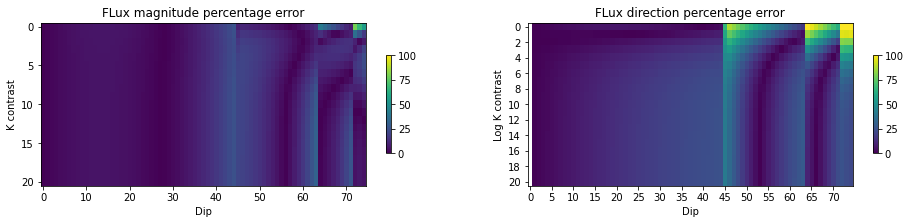

In [5]:
fig, axes = plt.subplots(1,2, figsize=(16, 3))

ax = plt.subplot(121)
cb = ax.imshow(qmag_results*100, vmin = 0, vmax = 100, aspect = 'auto')
ax.set_title('FLux magnitude percentage error')
ax.set_xlabel('Dip')
ax.set_ylabel('K contrast')
plt.colorbar(cb, shrink = 0.6)

ax = plt.subplot(122)
cb = ax.imshow(qtheta_results*100, vmin = 0, vmax = 100, aspect = 'auto')
ax.set_title('FLux direction percentage error')
ax.set_xlabel('Dip')
ax.set_ylabel('Log K contrast')
plt.colorbar(cb, shrink = 0.6)

ax = plt.gca()
ax.set_xticks(np.arange(0, 75, 5))
ax.set_xticklabels(np.arange(0, 75, 5))
ax.set_yticks(np.arange(0, len(Kcontrast), 2))
#ylabels = [value for index, value in enumerate(logfunc(Kcontrast)) if index % 2 == 1]
#ylabels2 = ["%.1f" % i for i in ylabels]
#ax.set_yticklabels(ylabels2)
plt.show()

Text(0, 0.5, 'Percentage Error (%)')

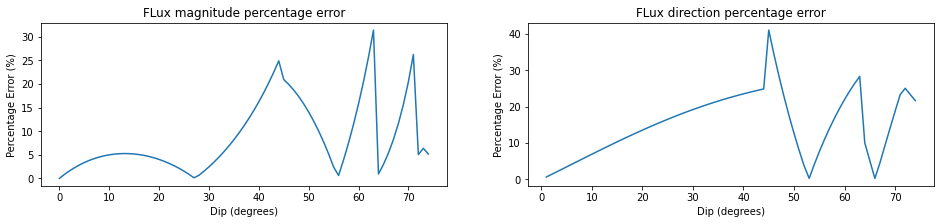

In [6]:
fig, axes = plt.subplots(1,2, figsize=(16, 3))
ax = plt.subplot(121)
ax.plot(dip,qmag_results[-1]*100)
ax.set_title('FLux magnitude percentage error')
#ax.set_xticklabels(dip)
#ax.set_xticks(np.arange(0,len(dip),1))
#ax.set_yticklabels(Kcontrast)
#ax.set_yticks(np.arange(0,len(Kcontrast),1))
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('Percentage Error (%)')

ax = plt.subplot(122)
ax.plot(dip,qtheta_results[-1]*100)
ax.set_title('FLux direction percentage error')
#ax.set_xticklabels(dip)
#ax.set_xticks(np.arange(0,len(dip),1))
#ax.set_yticklabels(Kcontrast)
#ax.set_yticks(np.arange(0,len(Kcontrast),1))
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('Percentage Error (%)')



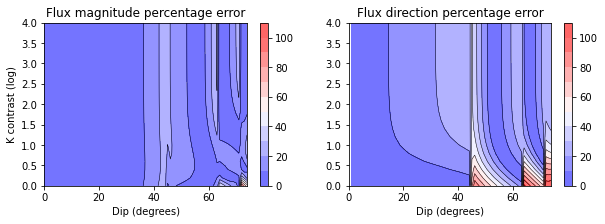

In [7]:
x = dip
y = logfunc(Kcontrast)

fig, axes = plt.subplots(1,2, figsize=(10, 3))
levels = [0,10,20,30,40,50,60,70,80,90,100,1000]
   
# FLUX MAG
ax = plt.subplot(121)
ax.set_title('Flux magnitude percentage error')
z = qmag_results*100

contourf_ = ax.contourf(x,y,z, levels, vmin = 0, vmax = 100, cmap = 'bwr', alpha = 0.6)
ax.contour(x,y,z, levels, colors = 'Black', linewidths=0.5, linestyles = 'solid')
cbar = fig.colorbar(contourf_) 
ax.set_xlabel('Dip (degrees)')
ax.set_ylabel('K contrast (log)')

# FLUX ANGLE
ax = plt.subplot(122)
ax.set_title('Flux direction percentage error')
ax.set_xlabel('Dip (degrees)')

z = qtheta_results*100
contourf_ = ax.contourf(x,y,z, levels, vmin = 0, vmax = 100, cmap = 'bwr', alpha = 0.6)
ax.contour(x,y,z, levels, colors = 'Black', linewidths=0.5, linestyles = 'solid')
cbar = fig.colorbar(contourf_) 
  
if scenario == 0 : plt.savefig('2Dplot_VO.tif', dpi=450)
if scenario == 1 : plt.savefig('2Dplot_VO_XT3D.tif', dpi=450)
if scenario == 2 : plt.savefig('2Dplot_VS.tif', dpi=450)
if scenario == 3 : plt.savefig('2Dplot_VS_XT3D.tif', dpi=450)